<a href="https://colab.research.google.com/github/Gianmarco20/Finanzas/blob/main/Propuesta_de_inversi%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyhomebroker
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from pyhomebroker import HomeBroker
import requests
import yfinance as yf

desde = dt.date(2015, 1, 1)
hasta = (dt.date.today() - dt.timedelta(days = 1))

In [2]:
ypf = yf.download(tickers = 'YPF', auto_adjust = True, start = desde.strftime('%Y-%m-%d'), end = hasta.strftime('%Y-%m-%d'))['Close']

[*********************100%%**********************]  1 of 1 completed


In [3]:
url_lideres = 'https://iol.invertironline.com/mercado/cotizaciones/argentina/acciones/panel-l%C3%ADderes'
html_lideres = requests.get(url_lideres, verify = False).content
df_lideres = pd.read_html(html_lideres)[0]
df_lideres['Símbolo'] = df_lideres['Símbolo'].apply(lambda row: row.split()[0])
list_panel_lider = df_lideres['Símbolo'].to_list()

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'iol.invertironline.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [4]:
url_general = 'https://iol.invertironline.com/mercado/cotizaciones/argentina/acciones/panel-general'
html_general = requests.get(url_general, verify = False).content
pd_general = pd.read_html(html_general)[0]
pd_general['Símbolo'] = pd_general['Símbolo'].apply(lambda row: row.split()[0])
list_panel_general = pd_general['Símbolo'].to_list()

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'iol.invertironline.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [5]:
list_renta_variable = list_panel_lider + list_panel_general
list_renta_fija_ley_ny = ['GD29D', 'GD30D', 'GD35D', 'GD38D', 'GD41D', 'GD46D']
list_renta_fija_ley_local = ['AE38D', 'AL29D', 'AL30D', 'AL35D', 'AL41D']
list_tickers = list_renta_variable + list_renta_fija_ley_ny + list_renta_fija_ley_local

In [6]:
broker = 265
dni = 42193912
user = 'Gcaserta'
password = 'CasaPadua23'
hb = HomeBroker(broker_id = broker)
hb.auth.login(dni = dni, user = user, password = password, raise_exception = True)

tickers_data = {}

for ticker in list_tickers:
  data = hb.history.get_daily_history(symbol = ticker, from_date = desde, to_date = hasta)
  data['date'] = pd.to_datetime(data['date'], format = '%Y-%m-%d')
  data.set_index(data['date'], inplace = True)
  data = data['close']
  tickers_data[f'{ticker}'] = data

df_tickers_data = pd.DataFrame(tickers_data)
df_tickers_data = pd.concat([df_tickers_data, ypf], axis = 1)
df_tickers_data.rename(columns = {'Close': 'YPF'}, inplace = True)
df_tickers_data['CCL'] = round(df_tickers_data['YPFD'] / df_tickers_data['YPF'], 3)

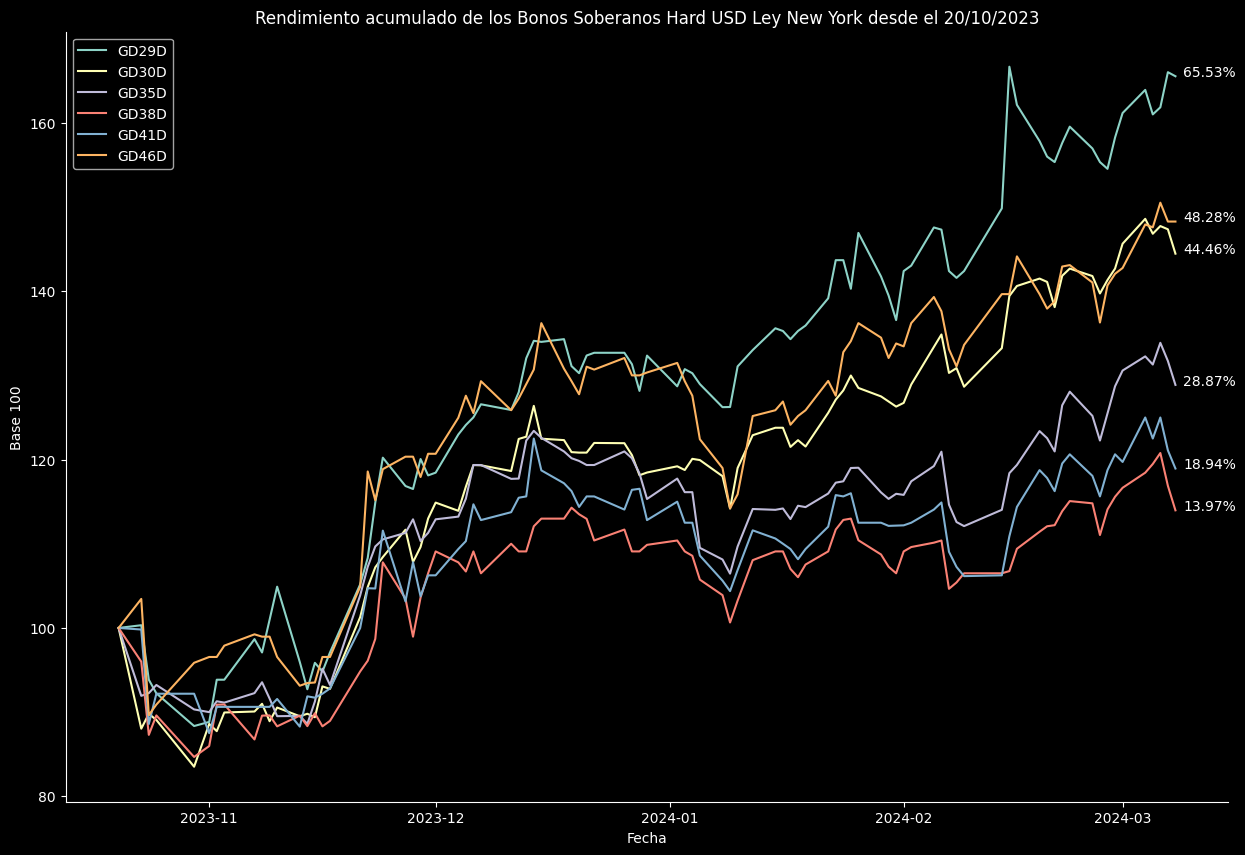

In [7]:
df_ley_ny = df_tickers_data.loc[:, list_renta_fija_ley_ny].dropna()
df_ley_ny = df_ley_ny[df_ley_ny.index.date >= dt.date(2023, 10, 20)]
df_ley_ny = df_ley_ny.divide(df_ley_ny.iloc[0]) * 100

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize = (15, 10))
for ticker in df_ley_ny.columns:
  plt.plot(df_ley_ny[ticker], label = ticker)
  plt.annotate(text = f'{round(df_ley_ny[ticker][-1] - 100, 2)}%', xy = (df_ley_ny.index.date[-1] + dt.timedelta(days = 1), df_ley_ny[ticker][-1]))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title(f'Rendimiento acumulado de los Bonos Soberanos Hard USD Ley New York desde el {df_ley_ny.index[0].date().strftime("%d/%m/%Y")}')
plt.xlabel('Fecha')
plt.ylabel('Base 100')
plt.legend()
plt.show()

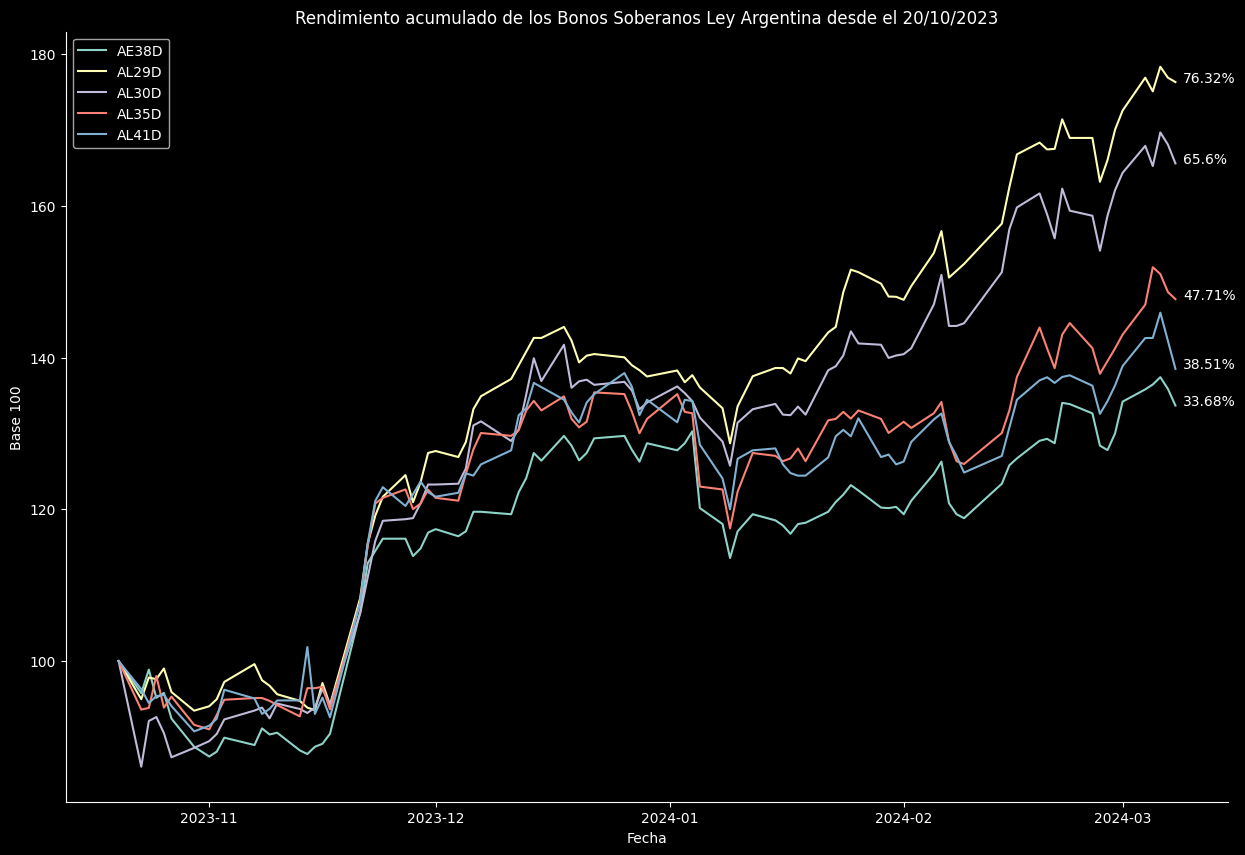

In [8]:
df_ley_local = df_tickers_data.loc[:, list_renta_fija_ley_local].dropna()
df_ley_local = df_ley_local[df_ley_local.index.date >= dt.date(2023, 10, 20)]
df_ley_local = df_ley_local.divide(df_ley_local.iloc[0]) * 100

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize = (15, 10))
for ticker in df_ley_local.columns:
  plt.plot(df_ley_local[ticker], label = ticker)
  plt.annotate(text = f'{round(df_ley_local[ticker][-1] - 100, 2)}%', xy = (df_ley_local.index.date[-1] + dt.timedelta(days = 1), df_ley_local[ticker][-1]))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title(f'Rendimiento acumulado de los Bonos Soberanos Ley Argentina desde el {df_ley_local.index[0].date().strftime("%d/%m/%Y")}')
plt.xlabel('Fecha')
plt.ylabel('Base 100')
plt.legend()
plt.show()

5 AR Bonos Soberanos USD 2024 02.svg

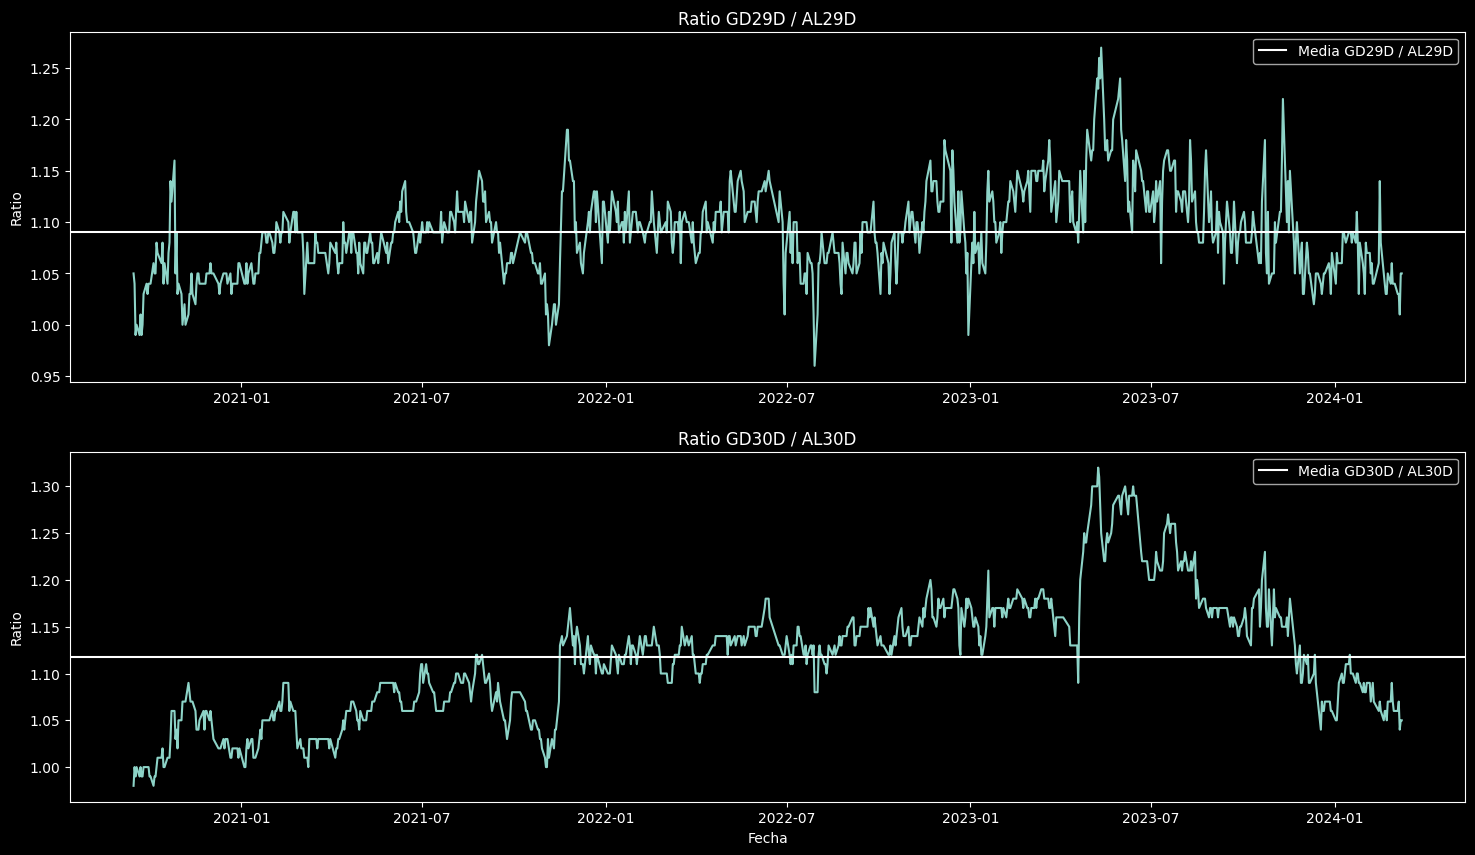

In [9]:
bonos_ratio = ['GD29D', 'AL29D', 'GD30D', 'AL30D']
df_ratios = df_tickers_data.loc[:, bonos_ratio].dropna()
df_ratios['GD29D/AL29D'] = round(df_ratios['GD29D'] / df_ratios['AL29D'], 2)
df_ratios['GD30D/AL30D'] = round(df_ratios['GD30D'] / df_ratios['AL30D'], 2)

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize = (18, 10), ncols = 1, nrows = 2)
ax[0].plot(df_ratios['GD29D/AL29D'])
ax[0].set_title('Ratio GD29D / AL29D')
ax[0].set_ylabel('Ratio')
ax[0].axhline(df_ratios['GD29D/AL29D'].mean(), label = 'Media GD29D / AL29D')
ax[0].legend()
ax[1].plot(df_ratios['GD30D/AL30D'])
ax[1].set_title('Ratio GD30D / AL30D')
ax[1].set_ylabel('Ratio')
ax[1].axhline(df_ratios['GD30D/AL30D'].mean(), label = 'Media GD30D / AL30D')
ax[1].set_xlabel('Fecha')
ax[1].legend()
plt.show()

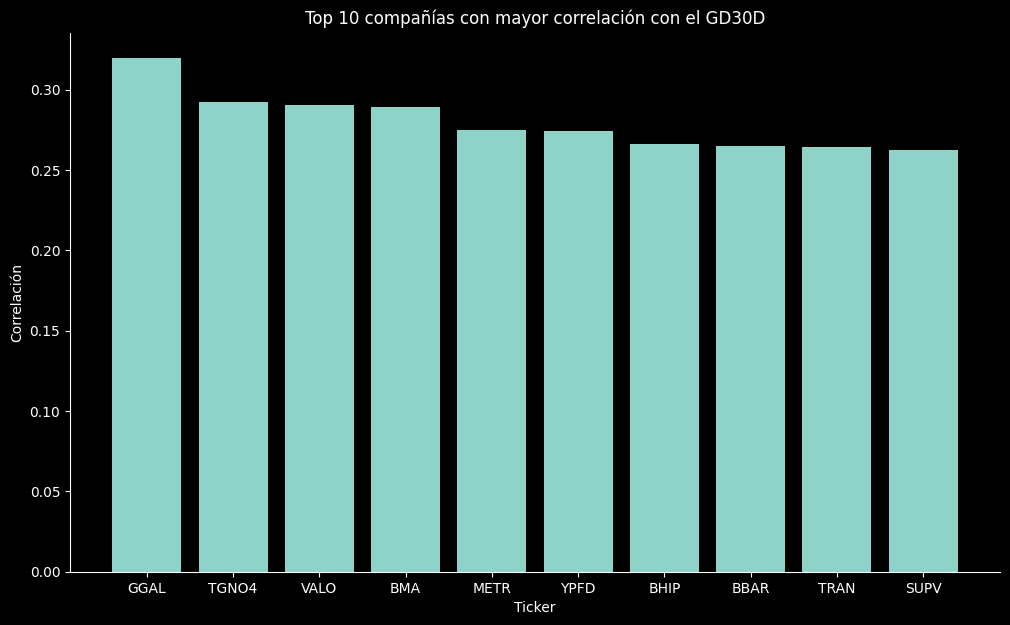

In [10]:
df_variaciones = df_tickers_data.pct_change()
df_corr = df_variaciones.corr()
df_corr = df_corr['GD30D']
df_corr = df_corr.loc[list_renta_variable]
df_corr = df_corr.sort_values(ascending = False)
df_corr = df_corr.iloc[:10]

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize = (12, 7))
plt.bar(x = df_corr.index, height = df_corr.values)
plt.title('Top 10 compañías con mayor correlación con el GD30D')
plt.xlabel('Ticker')
plt.ylabel('Correlación')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

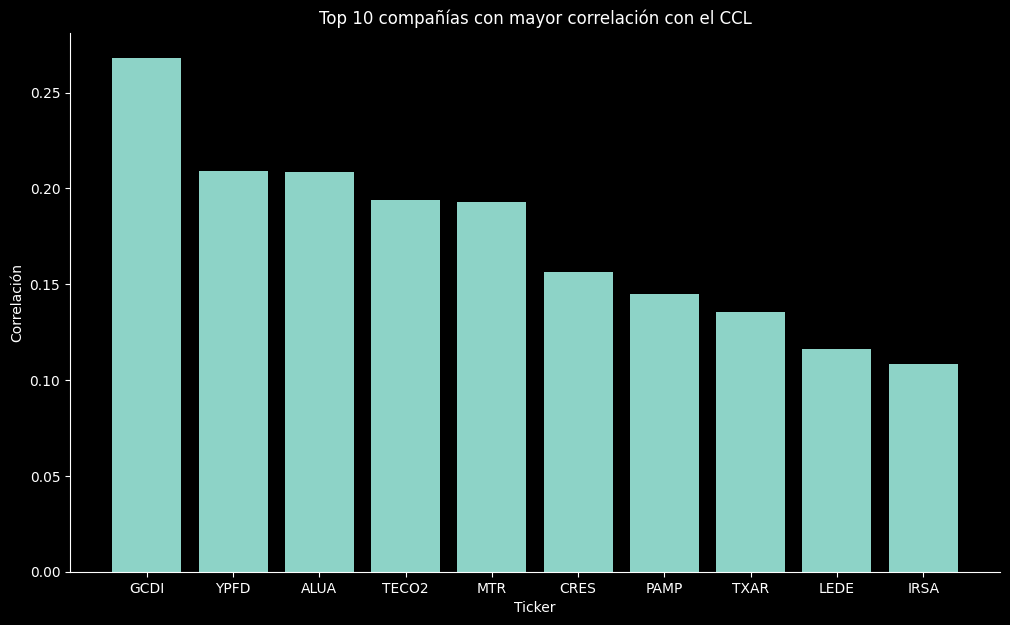

In [11]:
df_ccl_corr = df_tickers_data.pct_change()
df_ccl_corr = df_ccl_corr.corr()
df_ccl_corr = df_ccl_corr['CCL']
df_ccl_corr = df_ccl_corr.sort_values(ascending = False)
df_ccl_corr = df_ccl_corr.iloc[1:11]

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize = (12, 7))
plt.bar(x = df_ccl_corr.index, height = df_ccl_corr.values)
plt.title('Top 10 compañías con mayor correlación con el CCL')
plt.xlabel('Ticker')
plt.ylabel('Correlación')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

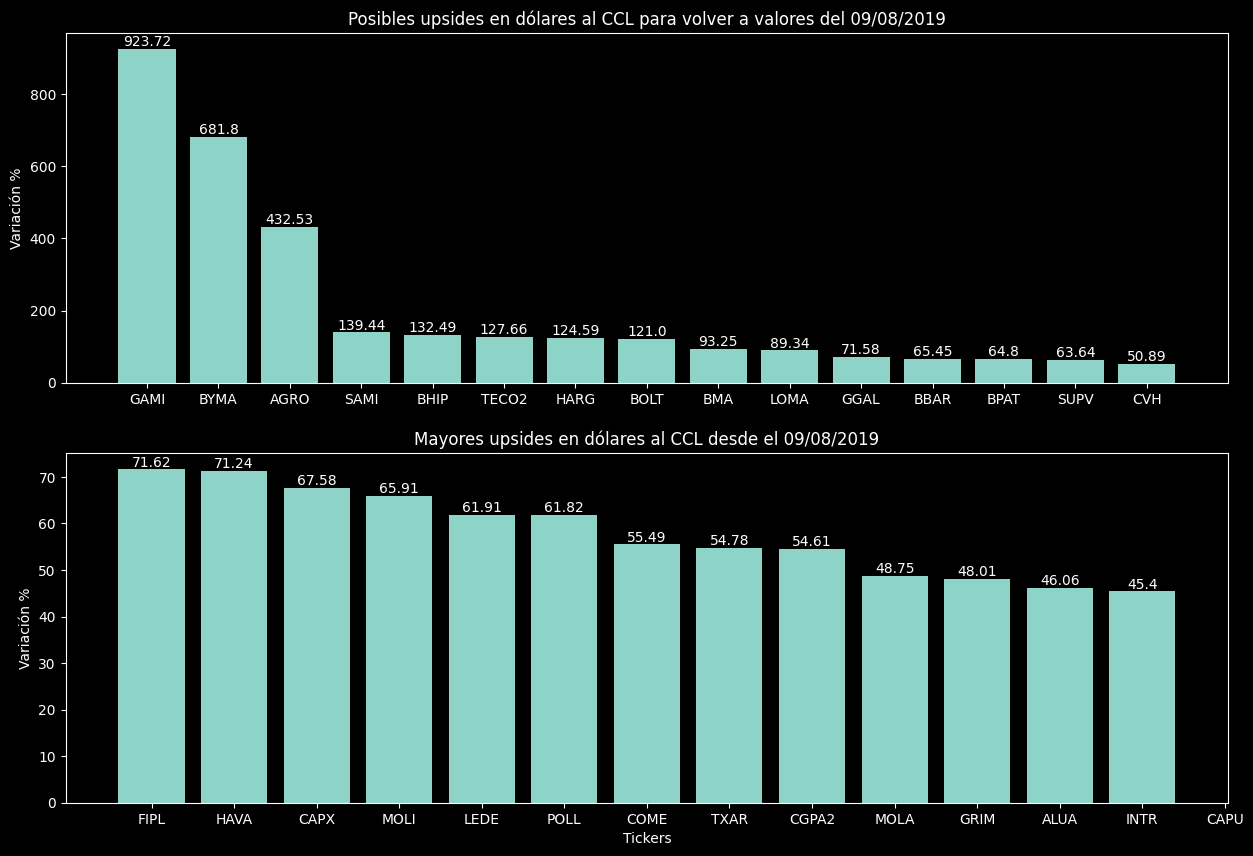

In [12]:
potenciales_upsides = df_tickers_data.loc[:, list_renta_variable]
potenciales_upsides = potenciales_upsides.divide(df_tickers_data['CCL'], axis = 0)
potenciales_upsides = potenciales_upsides[potenciales_upsides.index.date >= dt.date(2019, 8, 9)]
potenciales_upsides = potenciales_upsides.apply(lambda col: col.fillna(col.dropna().iloc[0] if not col.dropna().empty else col))
potenciales_upsides = potenciales_upsides.divide(potenciales_upsides.iloc[-1]) - 1
potenciales_upsides = potenciales_upsides.iloc[0]
potenciales_upsides = potenciales_upsides.sort_values(ascending = False)
potenciales_upsides_alza = potenciales_upsides.iloc[:15]
potenciales_upsides_alza = potenciales_upsides_alza * 100
mayores_upsides = abs(potenciales_upsides.iloc[-15:-1])
mayores_upsides = mayores_upsides.sort_values(ascending = False)
mayores_upsides = mayores_upsides * 100

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize = (15, 10), ncols = 1, nrows = 2)
bars1 = ax[0].bar(x = potenciales_upsides_alza.index, height = potenciales_upsides_alza.values)
ax[0].set_title(f'Posibles upsides en dólares al CCL para volver a valores del {dt.date(2019, 8, 9).strftime("%d/%m/%Y")}')
ax[0].set_ylabel('Variación %')
for bar in bars1:
    yval = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha = 'center', va = 'bottom')
bars2 = ax[1].bar(x = mayores_upsides.index, height = mayores_upsides.values)
ax[1].set_title(f'Mayores upsides en dólares al CCL desde el {dt.date(2019, 8, 9).strftime("%d/%m/%Y")}')
ax[1].set_ylabel('Variación %')
ax[1].set_xlabel('Tickers')
for bar in bars2:
    yval = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha = 'center', va = 'bottom')
plt.show()